In [37]:
%pylab inline
import torch

Populating the interactive namespace from numpy and matplotlib


/home/marco/anaconda3/envs/mib/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['rc', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [38]:
import wandb
import inspect
import seaborn as sns
import pandas as pd
import json
from tqdm.notebook import tqdm
import os
import yaml


class ResultsManager:
    def __init__(self, wandb_user, wandb_project, algorithm_info_file, dataset_info_file, sid_info_file, verbose=False):
        self.api = wandb.Api()
        self.verbose = verbose
        self.wandb_user = wandb_user
        self.wandb_project = wandb_project
        
        with open(dataset_info_file, 'r') as stream:
            self.datasets_info = yaml.safe_load(stream)
    
        with open(sid_info_file,'r') as stream:
            self.sid_info = yaml.safe_load(stream)

        with open(algorithm_info_file,'r') as stream:
            self.algorithms_info = yaml.safe_load(stream)
        
        if verbose:
            print('User: %s' % wandb_user)
            print('Project: %s' % wandb_project)
            print('Algorithms: %s' % str(list(self.algorithms_info.keys())))
            print('Datasets: %s' % str(list(self.datasets_info.keys())))
            
    def sid2sweep(self, sid):
        return self.api.sweep('%s/%s'%(self.wandb_project, sid))
    
    def get_name(self, idx):
        if idx in self.datasets_info:
            return self.datasets_info[idx]['name']
        elif idx in self.algorithms_info:
            return self.algorithms_info[idx]['name']
        else:
            raise Exception('%s name not found')
            
    def datalg2uid(self, dataset, algorithm):
        return dataset+'-'+algorithm
    
    def sid2datalg(self, sid):
        uids = [uid for uid in self.sid_info if sid in self.sid_info[uid]['sid']]
        assert len(uids) == 1
        return self.uid2datalg(uids[0])

    def uid2datalg(self, uid):
        datalg = uid.split('-')
        return datalg[0], datalg[1]

    def get_sweep(self, dataset, algorithm):
        name = self.datalg2uid(dataset, algorithm)
        sid = self.sid_info[name]['id']
        return self.sid2sweep(sid)
    
    def get_runs(self, dataset, algorithm):
        name = self.datalg2uid(dataset, algorithm)
        sid = self.sid_info[name]['sid']
        if not isinstance(sid, list):
            sid = [sid]
            
        runs = []
        for s in sid:
            runs += self.sid2sweep(s).runs
        return runs
    
    def get_algorithms(self, dataset=None):
        if dataset:
            return [alg for alg in self.algorithms_info.keys() 
                    if self.datalg2uid(dataset,alg) in self.sid_info]
        else:
            return [alg for alg in self.algorithms_info.keys()]
        
    def get_run_config(self, run):
        dataset, algorithm = self.sid2datalg(run.sweep.id)
        key_lookup = self.algorithms_info[algorithm]['params']
        return {key: run.config[value['config_key']] for key,value in key_lookup.items()}
    

if 'WANDB_USER' in os.environ:
    wandb_user = os.environ['WANDB_USER']
else:
    raise Exception('Please set WANDB_USER')
    
if 'WANDB_PROJECT' in os.environ:
    wandb_project = os.environ['WANDB_PROJECT']
else:
    raise Exception('Please set WANDB_PROJECT')

    
rm = ResultsManager(wandb_user=wandb_user, 
                    wandb_project=wandb_project, 
                    algorithm_info_file='results/algorithms.yml', 
                    dataset_info_file='results/datasets.yml', 
                    sid_info_file='results/ids.yml', 
                    verbose=True)


User: mfederici
Project: causal-mib
Algorithms: ['ECI', 'EI', 'VREx', 'VIB', 'IRM']
Datasets: ['D_CMNIST', 'D_CMNIST_v2', 'D_CMNIST_v3']


In [39]:
def decorate_plot(config, ax):
    for name, point in config['plot'].items():
        ax.plot(point['coord'][0], point['coord'][1], label='$%s$'%name, **point['params'])  

    ax.set_xlim(*config['lims']['x'])
    ax.set_ylim(*config['lims']['y'])

    ax.set_xlabel('$\\mathbb{E}_{train}[-\\log\\ q_\\theta(y|x)]$', size=15)
    ax.set_ylabel('$\\mathbb{E}_{test}[-\\log\\ q_\\theta(y|x)]$', size=15)
    

In [40]:


def plot_data(all_data, ax, color=None,uncertainty_alpha=0.5, label=None):
    points = []
    for data in all_data:
        mu = np.mean(data, axis=0)
        sigma = np.cov(data, rowvar=0)

        U, s, _ = numpy.linalg.svd(sigma)

        ax.plot(mu[0],mu[1],'.', color=color)
        ax.plot([mu[0]-U[0,0]*s[0]**0.5,mu[0]+U[0,0]*s[0]**0.5],[mu[1]-U[0,1]*s[0]**0.5,mu[1]+U[0,1]*s[0]**0.5],
                '-',color=color, alpha=uncertainty_alpha)
        ax.plot([mu[0]-U[1,0]*s[1]**0.5,mu[0]+U[1,0]*s[1]**0.5],[mu[1]-U[1,1]*s[1]**0.5,mu[1]+U[1,1]*s[1]**0.5],
                '-',color=color, alpha=uncertainty_alpha)
        points.append(mu.reshape(1,-1))
    points = np.concatenate(points,0)
    ax.plot(points[:,0], points[:,1], color=color, label=label)    
    
    
def plot_data_points(all_data, ax, color=None,uncertainty_alpha=0.5, label=None):
    all_data = pd.concat(all_data)
    
    x_min, x_max = all_data['train'].min(),all_data['train'].max()
    
    n = 3  # degree of polynomial
    p, C_p = np.polyfit(all_data['train'], all_data['test'], n, cov=True)  # C_z is estimated covariance matrix

    # Do the interpolation for plotting:
    t = np.linspace(x_min, x_max, 100)
    # Matrix with rows 1, t, t**2, ...:
    TT = np.vstack([t**(n-i) for i in range(n+1)]).T
    yi = np.dot(TT, p)  # matrix multiplication calculates the polynomial values
    C_yi = np.dot(TT, np.dot(C_p, TT.T)) # C_y = TT*C_z*TT.T
    sig_yi = np.sqrt(np.diag(C_yi))  # Standard deviations are sqrt of diagonal

    # Do the plotting:
    ax.fill_between(t, yi+sig_yi, yi-sig_yi, alpha=.25, color=color) 
    ax.plot(t, yi,'-', color=color, label=label) 
    ax.plot(all_data['train'],all_data['test'],'.',color=color, alpha=0.1) 


def plot_sweep_result(runs, get_last_run_data, sortkey, ax, uncertainty_alpha=0.5, color=None, label=None, consider_last=1000):
    points = []
    reg_strenght = []
    all_data = [get_last_run_data(run, consider_last=consider_last) for run in runs]
    #sortby = [json.loads(run.json_config)[sortkey]['value'] for run in sweep.runs]
    #order = np.argsort(sortby)
    
    #print(order)
    if len(all_data)>0:
        plot_data_points(all_data, ax, color=color, uncertainty_alpha=uncertainty_alpha, label=label)





In [41]:
def get_last_mixed_data(run, consider_last=None, samples=None):
        if consider_last is None:
            h = run.history(samples=samples, pandas=False)
        else:
            min_step = run.lastHistoryStep-consider_last
            h = run.scan_history(min_step=min_step)
        data = [{'train':(r['test_ce_01']+r['test_ce_02'])/2.0, 
                        'test':r['test_ce_09'],
                        'step': r['_step']} for r in h if 'test_ce_01' in r]
        return pd.DataFrame(data)
    
def get_last_data(run, consider_last=None):
        if consider_last is None:
            h = run.scan_history()
        else:
            min_step = run.lastHistoryStep-consider_last
            h = run.scan_history(min_step=min_step)
        data = [{'train':r['train_ce'], 
                 'test':r['test_ce'],
                 'step': r['_step']} for r in h if 'test_ce' in r]
        return pd.DataFrame(data)
    
def sample_data(run, samples=None, consider_last=None):
    h = run.history(samples=samples, pandas=False)
        
    data = [{'train':r['train_ce'], 
             'test':r['test_ce'],
             'step': r['_step']} for r in h if 'test_ce' in r]
    return pd.DataFrame(data)

    
def _get_last_data(run, consider_last=None):
        if consider_last is None:
            h = run.scan_history()
        else:
            min_step = run.lastHistoryStep-consider_last
            h = run.scan_history(min_step=min_step)
        data = [{'train':r['CE(train_t0)'], 
                 'test':r['CE(test_t1)'],
                 'step': r['_step']} for r in h if 'CE(test_t1)' in r]
        return pd.DataFrame(data)
    
def _sample_data(run, samples=None, consider_last=None):
    h = run.history(samples=samples, pandas=False)
        
    data = [{'train':r['CE(train_t0)'], 
             'test':r['CE(test_t1)'],
             'step': r['_step']} for r in h if 'CE(test_t1)' in r]
    return pd.DataFrame(data)

process_run = {
    'D_CMNIST': {
        'get_last': _get_last_data,
        'get_all': _get_last_data,
        'sample': _sample_data
    },
    'D_CMNIST_v2': {
        'get_last': _get_last_data,
        'get_all': _get_last_data,
        'sample': _sample_data
    },
    'D_CMNIST_v3': {
        'get_last': _get_last_data,
        'get_all': _get_last_data,
        'sample': _sample_data
    },
    'SpeechCommands': {
        'get_last': get_last_data,
        'get_all': get_last_data,
        'sample': sample_data,
    }
    
}

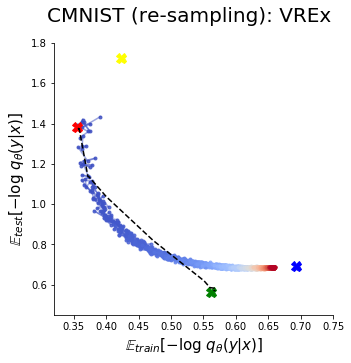

In [50]:
dataset = 'D_CMNIST'
algorithm = 'VREx'

runs = rm.get_runs(dataset=dataset, algorithm=algorithm)

cmap = plt.get_cmap('coolwarm')

f, ax = plt.subplots(1,len(runs), figsize=(5*len(runs),5), sharex=True, sharey=True)
if len(runs)==1:
    ax = [ax]

sns.despine()

f.suptitle('%s: %s'%(rm.get_name(dataset), rm.get_name(algorithm)), size=20)

for j,run in enumerate(tqdm(runs)):
    config_key = rm.algorithms_info[algorithm]['params']['beta']['config_key']
    #ax[j].set_title('$\\beta$= %f'%(run.config[config_key]))
        
    run_data = process_run[dataset]['sample'](run,10000)
    colors = np.array([cmap(v/run_data['step'].values.max()) for v in run_data['step'].values[:len(run_data['step'].values)]])
    
    
    for i in range(len(colors)):
        ax[j].plot(run_data['train'][i], run_data['test'][i],'.',color=colors[i], alpha=0.8)
        ax[j].plot(run_data['train'][i:i+2], run_data['test'][i:i+2],'-',color=colors[i], alpha=0.5)
        
    decorate_plot(rm.datasets_info[dataset], ax[j])

        

        #ax[j].set_title(run_name, fontsize=20)

#ax[-1].legend(fontsize=12)

In [61]:
dataset = 'D_CMNIST'

recompute = False
arch_filepath = 'definitions/architectures/CMNIST.py'
save_path = 'results/final_eval'

data_filepath = os.path.join(save_path,'%s.yml'%dataset)

from data import *
from eval.accuracy import AccuracyEvaluation, CrossEntropyEvaluation
from utils.run_manager.wandb import WANDBRunManager

datasets = {}

datasets['train_t0'] = DynamicCMNIST(path='datasets/MNIST', split='train+valid', 
                         cond_dist_file='data/cmnist_resources/%s_t0.pyt'%(dataset))
datasets['train_t1'] = DynamicCMNIST(path='datasets/MNIST', split='train+valid', 
                         cond_dist_file='data/cmnist_resources/%s_t1.pyt'%(dataset))
datasets['test_t0'] = DynamicCMNIST(path='datasets/MNIST', split='test', 
                         cond_dist_file='data/cmnist_resources/%s_t0.pyt'%(dataset))
datasets['test_t1'] = DynamicCMNIST(path='datasets/MNIST', split='test', 
                         cond_dist_file='data/cmnist_resources/%s_t1.pyt'%(dataset))

results = []
ids = []

if os.path.isfile(data_filepath):
    with open(data_filepath, 'r') as file:
        results = yaml.safe_load(file)
    ids = [row['rid'] for row in results]

for algorithm in rm.get_algorithms(dataset):
    runs = rm.get_runs(dataset, algorithm)
    print(algorithm)
    
    for run in tqdm(runs):
        if run.id in ids and not recompute:
            print('%s: already computed'%run.id)
            continue
        
        run_manager = WANDBRunManager(experiments_root='.', arch_filepath=arch_filepath, 
                                      desc=None, run_id=run.id, verbose=False, init=False)
        try:
            trainer, _ = run_manager.make_instances()
        except Exception as e:
            print(e)
            continue

        evaluators = {}
        for d in datasets:
            evaluators['CE(%s)'% d] = CrossEntropyEvaluation(trainer=trainer, datasets=datasets, evaluate_on=d)

        evaluation = {}
        for name, evaluator in tqdm(evaluators.items()):
            evaluation[name] = float(evaluator.evaluate()['value'])

        evaluation['rid'] = run.id

        results.append(evaluation)


with open(data_filepath, 'w') as file:
    yaml.dump(results, file)
    
results = pd.DataFrame(results)

ECI


dt4o8txg: already computed
zigk47qo: already computed
qkmfj61c: already computed
ybyyiev1: already computed
y8l2okmo: already computed
ewn1jgpw: already computed
1ip3nnz3: already computed
o55vifsj: already computed
hfituq3o: already computed

EI


42m8hnz1: already computed
l7v67x1d: already computed
twep49ix: already computed
1d69wo60: already computed
rktopchd: already computed
duso7mjz: already computed
a2m5md32: already computed
lc97nr4p: already computed
ey7xhyz6: already computed

VREx


j491bfz2: already computed
36d07ztk: already computed
kvosxnzj: already computed
5el7h91l: already computed
13jhpson: already computed
kcmehjiw: already computed

VIB


d3g03gt4: already computed
0t5zoiua: already computed
hepbswz2: already computed
3b6bckt1: already computed
its8jpcc: already computed
lvx9aj29: already computed



In [41]:
dataset = 'D_CMNIST'


data_filepath = os.path.join(save_path,'%s.yml'%dataset)
with open(data_filepath, 'r') as file:
    results = yaml.safe_load(file)
    
results = pd.DataFrame(results)

data = []


for algorithm in rm.get_algorithms(dataset):
    runs = rm.get_runs(dataset, algorithm)
    print(algorithm)
    
    for run in tqdm(runs):
        config = rm.get_run_config(run)
        config['algorithm'] = rm.get_name(algorithm)
        config['rid']= run.id
        res = results[results['rid']==run.id].to_dict('records')
        if len(res)>0:
            config.update(res[0])
   
    
        data.append(config)
        
data = pd.DataFrame(data)

ECI



EI



VREx



VIB


In [42]:
sid = '1'
[uid for uid in rm.sid_info if sid in rm.sid_info[uid]['sid']]

[]

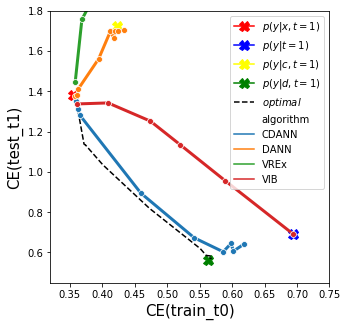

In [40]:
pd_data = pd.DataFrame(data)
f, ax = plt.subplots(1,1,figsize=(5,5))
decorate_plot(rm.datasets_info[dataset], ax)
sns.lineplot(data=pd_data, x='CE(train_t0)',y='CE(test_t1)', marker='o',linewidth=3, hue='algorithm')
ax.legend()

In [44]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

In [45]:
def make_animation(run, ax, x='CE(train_t0)', y='CE(test_t1)', n=10, color='b', samples=1000):
    
    print('Scanning history')
    h = run.history(samples=samples, pandas=False)
    
    data = [{'x':r[x], 
                 'y':r[y],
                 'step': r['_step']} for r in h if y in r]
   
    lines = []
    i = 0
    for k in range(n):
        idx = i-k
        idx_ = idx-1
        if idx<0:
            idx=0
        if idx_<0:
            idx_=0
        alpha = 1-(float(k+1.0)/(n+1.0))
        line, = ax.plot([], [], '.-', color=color, alpha=alpha)
        lines.append(line)
    
    # initialization function: plot the background of each frame
    def init():
        for k in range(n):
            idx = i-k
            idx_ = idx-1
            if idx<0:
                idx=0
            if idx_<0:
                idx_=0
            alpha = float(k+1.0)/(n+1.0)
            lines[k].set_data([data[idx_]['x'],data[idx]['x']], [data[idx_]['y'],data[idx]['y']])
            lines[k].set_alpha(alpha)
        return lines

    # animation function. This is called sequentially
    def animate(i):
        for k in range(n):
            idx = i-k
            idx_ = idx-1
            if idx<0:
                idx=0
            if idx_<0:
                idx_=0
            alpha = 1-(float(k+1.0)/(n+1.0))
            lines[k].set_data([data[idx_]['x'],data[idx]['x']], [data[idx_]['y'],data[idx]['y']])
            lines[k].set_alpha(alpha)
        return lines
    
    print('Animating')
    # call the animator. blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(data), interval=50, blit=True)
    return anim

Scanning history
Animating


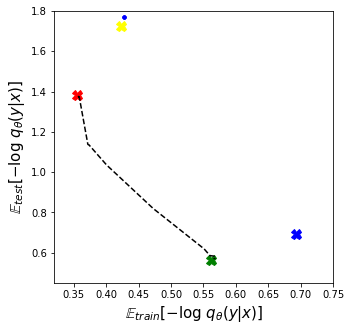

In [46]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots(1,1, figsize=(5,5))

decorate_plot(rm.datasets_info[dataset], ax)

anim = make_animation(runs[3], ax, n=5)

In [47]:
HTML(anim.to_html5_video())